In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import analyze # takes some time since inits hax
from channel_dict import channel_dict
from tqdm import tqdm
import datetime


%matplotlib inline

Using TensorFlow backend.


In [2]:
ACTUALLY_OFF = [1, 2, 12, 26, 34, 62, 65, 79, 86, 88, 102, 118, 
                130, 134, 135, 139, 148, 150, 152, 162, 178, 183,
                190, 198, 206, 213, 214, 234, 239, 244]

In [3]:
import hax
hax.init()

def data_exists(run_number):
    return os.path.exists('./data/run_%05d.h5' % run_number)

def all_data_exists(runlist):
    return all([data_exists(run) for run in runlist])

def file_to_list(runlist_file):
    return [int(run) for run in runlist_file.split('.')[0].split('_')[1:4]]

def get_run_time(run):
    return hax.runs.datasets[hax.runs.datasets.number == run].start.values[0]

In [43]:
runlists = [f for f in os.listdir('./runlists')]

bottom_runs = []
accs = []
errors = []

missing_runs = []
LED_off = []
resubmit_files = []

for f in tqdm(sorted(runlists)):
    runlist = file_to_list(f)
    if not all_data_exists(runlist):
        resubmit_files.append(f)
        #print('data missing for %s' % f)
        for r in runlist:
            if not data_exists(r):
                missing_runs.append(r)
        continue
        
    bottom_run = runlist[0]
    topbulk_run = runlist[1]
    topring_run = runlist[2]
    
    thresholds = analyze.get_thresholds(analyze.find_regular_run(bottom_run))
    
    acc, acc_errs = analyze.acceptance_3runs(bottom_run, topbulk_run, topring_run, thresholds)
    occ, occ_errs = analyze.occupancy_3runs(bottom_run, topbulk_run, topring_run)
    
    on_channels = np.where(occ > 0.05)[0]
    
    if len(on_channels) < 200:
        LED_off.append(f)
        #print('LED likely OFF for %s' % f)
        continue
    
    acc = acc[on_channels]
    acc_errs = acc_errs[on_channels]
    
    accs.append(np.mean(acc))
    errors.append(np.sqrt((acc_errs**2).sum()) / len(on_channels))
    bottom_runs.append(bottom_run)
    
print("These runs are missing data: ", missing_runs)
print("LED likely off for these files: ", LED_off)

 18%|█▊        | 18/99 [00:40<02:56,  2.17s/it]/home/ershockley/analysis/SPE/analyze.py:63: RuntimeWarning: divide by zero encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
/home/ershockley/analysis/SPE/analyze.py:63: RuntimeWarning: invalid value encountered in true_divide
  acc =  1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]
 41%|████▏     | 41/99 [01:27<01:54,  1.98s/it]/home/ershockley/analysis/SPE/analyze.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return led_firstN / noise_firstN
/home/ershockley/analysis/SPE/analyze.py:47: RuntimeWarning: invalid value encountered in true_divide
  return led_firstN / noise_firstN
/home/ershockley/analysis/SPE/analyze.py:56: RuntimeWarning: invalid value encountered in multiply
  noise *= corrections
/home/ershockley/analysis/SPE/analyze.py:31: RuntimeWarning: divide by zero encountered in log
  occupancy_array[:,i] = -1*np.log(self.make_correction(val

These runs are missing data:  [11536, 14371, 15087, 4511, 4512, 4513, 4848, 4851, 4850, 4956, 4958, 4957, 5949, 5950, 5951, 6248]
LED likely off for these files:  ['runlist_11277_11278_11279.txt', 'runlist_13433_13434_13435.txt', 'runlist_14088_14089_14090.txt']


In [32]:
noise_runs = []
noise_rms = []
noise_errors = [[],[]]

with open('/home/ershockley/analysis/SPE/noise_rms.csv') as f:
    for num, line in enumerate(f.readlines()):
        if num==0:
            continue
        line = line.split(',')
        run, rms, lower, upper = int(line[0]), float(line[1]), float(line[2]), float(line[3])
        noise_runs.append(run)
        noise_rms.append(rms)
        noise_errors[0].append(lower)
        noise_errors[1].append(upper)
        
noise_dates = [get_run_time(run) for run in noise_runs]

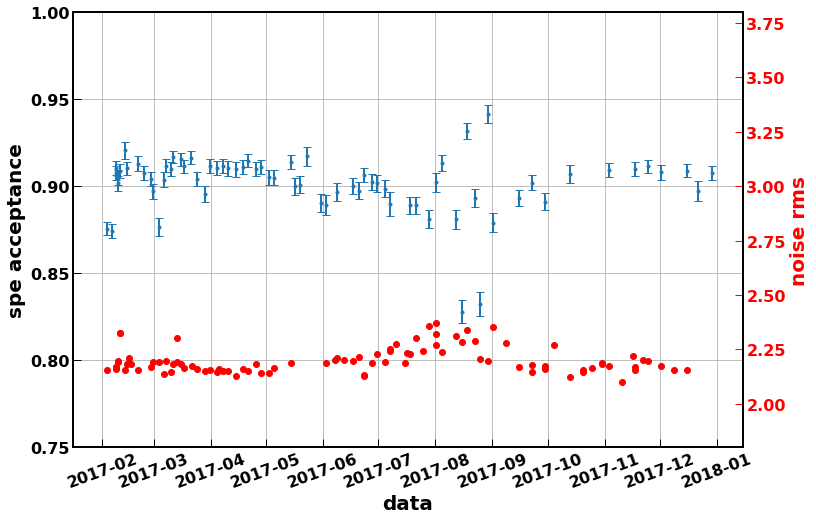

In [54]:
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
fmt = mdates.DateFormatter('%Y-%m')

dates = np.array([get_run_time(run) for run in bottom_runs])
bottom_runs = np.array(bottom_runs)
accs = np.array(accs)
errors = np.array(errors)

noisy_runs = [12768, 13837]

sr1 = np.where(bottom_runs > 6731)
sr1 = [i for i in sr1[0] if bottom_runs[i] not in noisy_runs]

plot_dates = dates[sr1]
plot_runs = bottom_runs[sr1]
plot_accs = accs[sr1]
plot_errors = errors[sr1]

f, ax = plt.subplots(figsize=(12,8))
#plt.errorbar(bottom_runs, accs, yerr=errors, linestyle='None', marker='.')
ax.errorbar(plot_dates, plot_accs, yerr=plot_errors, linestyle='None', marker='.')
ax.set_ylim(0.75, 1.0)
plt.xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=20)
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(fmt)
ax.grid()
ax.set_xlabel('data')
ax.set_ylabel('spe acceptance')

ax2 = ax.twinx()
ax2.scatter(noise_dates, noise_rms, color='red')
ax2.tick_params('y', colors='red')
ax2.set_ylabel('noise rms', color='red')
ax2.set_ylim(1.8,3.8)
plt.savefig('new_moneyplot.png')
plt.show()

In [17]:
def submit_job(file):
    command = "./submit_jobs.sh %s" % os.path.join('runlists', file)
    print(command)
    !{command}

In [18]:
for f in resubmit_files:
    submit_job(f)
    

./submit_jobs.sh runlists/runlist_11277_11278_11279.txt
noise run: 11276
LED runs: 11277
11278
11279
Deactivate:Unsetting ROOT environment variables..
Activate: ROOT has been sourced. Environment settings are ready. 
ROOTSYS=/project/lgrandi/anaconda3/envs/pax_head
Submitted batch job 41780202
./submit_jobs.sh runlists/runlist_11352_11353_11354.txt
noise run: 11351
LED runs: 11352
11353
11354
Deactivate:Unsetting ROOT environment variables..
Activate: ROOT has been sourced. Environment settings are ready. 
ROOTSYS=/project/lgrandi/anaconda3/envs/pax_head
Submitted batch job 41780225
./submit_jobs.sh runlists/runlist_11535_11536_11537.txt
noise run: 11534
LED runs: 11535
11536
11537
Deactivate:Unsetting ROOT environment variables..
Activate: ROOT has been sourced. Environment settings are ready. 
ROOTSYS=/project/lgrandi/anaconda3/envs/pax_head
Submitted batch job 41780252
./submit_jobs.sh runlists/runlist_14369_14370_14371.txt
noise run: 14368
LED runs: 14369
14370
14371
Deactivate:Uns

In [23]:
def find_file(run):
    return [f for f in os.listdir('runlists') if str(run) in f]

data_dir_base = 'data'
def acceptance_curve_3runs(bottom_run, topbulk_run, topring_run):
    ret_acc, ret_errs = np.ones((248, 1099)), np.ones((248, 1099))
    run_list = [bottom_run, topbulk_run, topring_run]
    channel_lists = [channel_dict['bottom_channels'],
                     channel_dict['top_bulk'],
                     channel_dict['top_outer_ring']]
    for run, ch_list in zip(run_list, channel_lists):
        path = os.path.join(data_dir_base, 'run_%05d.h5' % run)
        if not os.path.exists(path):
            print("Acceptance data does not exist for run %d" % run)
        s = analyze.SPE(path)
        frac, errs = s.acceptance_by_channel
        ret_acc[ch_list] = frac[ch_list]
        ret_errs[ch_list] = errs[ch_list]
    return ret_acc, ret_errs

12398
0.851812904967


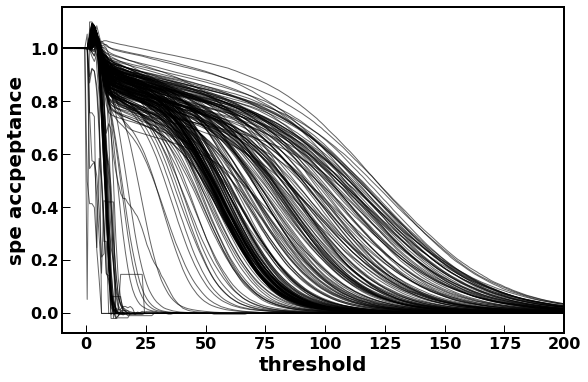

In [48]:
outlier_indices = np.where(accs < 0.85)
outliers = bottom_runs[outlier_indices]
run = outliers[1]
print(run)
s = analyze.SPE('data/run_%05d.h5' % run)
x = s.data['bin_centers'].copy()
runlist = file_to_list(find_file(run)[0])
#acc = s.acceptance(6)
acc, err = acceptance_curve_3runs(runlist[0], runlist[1], runlist[2])
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))

acc_frac = acc[np.arange(248), 100 + np.array(thresholds[:248])]
print(np.median(acc_frac))

plt.figure(figsize=(9,6))
for ch, a in enumerate(acc):
    plt.plot(x, a, color='black', linewidth=1, alpha=0.6)
    
plt.xlim(-10, 200)
plt.xlabel('threshold')
plt.ylabel('spe accpeptance')
#plt.savefig('acceptance_curve_%05d.png' % run)
plt.show()


In [ ]:
led = []
noise = []
for run in outliers:
    s = analyze.SPE('data/run_%05d.h5' % run)
    led.append(s.data['LED_amplitude'])
    noise.append(s.data['noise_amplitude'])

led = np.array(led)
noise = np.array(noise)

led = led.sum(axis=0)
noise = noise.sum(axis=0)

corr = led[:108, :].sum(axis=0) / noise[:108, :].sum(axis=0)

noise *= corr

residual = (led - noise).T

acceptance = 1 - residual.cumsum(axis=1) / residual.sum(axis=1)[:, np.newaxis]

acceptance = np.clip(acceptance, -0.1, 1.1)

plt.figure(figsize=(9,6))
for ch, acc in enumerate(acceptance):
    plt.plot(x, acc, color='k')
plt.xlim(-10,200)
plt.show()

In [ ]:
thresholds = analyze.get_thresholds(analyze.find_regular_run(int(run)))
new_accs = analyze.acceptance_3runs(*tuple(runlist), thresholds=thresholds)[0]
print(accs)

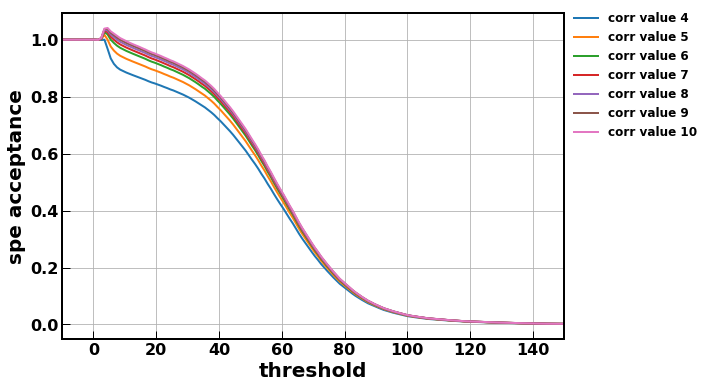

In [27]:
example_run = sorted(bottom_runs)[-1]
runlist = file_to_list(find_file(example_run)[0])
ch = 0
s = analyze.SPE('data/run_%05d.h5' % runlist[2])
x = s.data['bin_centers']
corr_values = [4,5,6,7,8,9,10]

plt.figure(figsize=(9,6))
for i in range(s.big_array.shape[-1]):
    accs = s.big_array[ch,:,i]
    plt.plot(x, accs, label='corr value %d' % corr_values[i])
plt.xlim(-10, 150)
plt.legend(loc=(1.01, 0.6))
plt.grid()
plt.xlabel('threshold')
plt.ylabel('spe acceptance')
plt.savefig('example_systematic.png')
plt.show()
    


In [ ]:
ch = 193
run = 11069
s = analyze.SPE('data/run_%05d.h5' % run)

x = s.data['bin_centers']

plt.figure(figsize=(9,6))
plt.plot(x, s.data['LED_amplitude'][:,ch], color ='black')
plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlim(-20, 50)
plt.yscale('log')
plt.show()

val = 4
plt.figure(figsize=(9,6))
plt.plot(x, s.residual(val)[ch], color ='black')
#plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlim(-20, 50)
#plt.yscale('log')
plt.show()

plt.figure(figsize=(9,6))
plt.plot(x, s.acceptance(val)[ch], color ='black')
#plt.plot(x, s.data['noise_amplitude'][:,ch], color='red' )
plt.xlim(-20, 50)
plt.show()



In [ ]:
data_dir_base = './data'
def acceptance_curve_3runs(bottom_run, topbulk_run, topring_run):
    ret_acc, ret_errs = np.ones((248, 1099)), np.ones((248, 1099))
    run_list = [bottom_run, topbulk_run, topring_run]
    channel_lists = [channel_dict['bottom_channels'],
                     channel_dict['top_bulk'],
                     channel_dict['top_outer_ring']]
    for run, ch_list in zip(run_list, channel_lists):
        path = os.path.join(data_dir_base, 'run_%05d.h5' % run)
        if not os.path.exists(path):
            print("Acceptance data does not exist for run %d" % run)
        s = analyze.SPE(path)
        frac, errs = s.acceptance_by_channel
        ret_acc[ch_list,:] = frac[ch_list,:]
        ret_errs[ch_list,:] = errs[ch_list,:]
        x = s.data['bin_centers']
    return x, ret_acc, ret_errs